# Original dataset

In [1]:
import numpy as np
import pandas as pd

# Original dataset
df_train_raw1 = pd.read_csv("TRAINING_BEFORE_JULY.csv")
df_test_raw1 = pd.read_csv("TEST_AUGUST.csv")

print(df_train_raw1.shape)
print(df_test_raw1.shape)

C:\Users\jeube\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\jeube\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


(3400829, 27)
(1742260, 27)


## Dataset after Removal (Missing values, Drop features, De-duplicate)

In [6]:
def clean_flight_data(df):
    """
    Cleans the flight data by:
    1. Dropping rows with any missing (NaN) values
    2. Removing rows where specific segment columns are structurally invalid
    3. Removing rows where any part of specific segment columns contains 'None'
    4. Removing rows with non-numeric or negative values
    5. Removing rows with invalid dates
    6. Dropping unnecessary columns
    7. Removing fully duplicated rows
    """

    # 1. Drop rows with any missing (NaN) values
    df_clean = df.dropna()

    # 2. Remove rows where specific segment columns are structurally invalid
    def is_structurally_invalid(val):
        try:
            val = str(val).strip()
            if val == "||":
                return True
            parts = val.split("||")
            if len(parts) == 2:
                return parts[0].strip() == "" or parts[1].strip() == ""
            return False
        except:
            return True

    multi_segment_cols = [
        'segmentsArrivalTimeEpochSeconds',
        'segmentsArrivalTimeRaw',
        'segmentsArrivalAirportCode',
        'segmentsDepartureAirportCode',
        'segmentsAirlineName',
        'segmentsAirlineCode',
        'segmentsEquipmentDescription',
        'segmentsDurationInSeconds',
        'segmentsDistance',
        'segmentsCabinCode'
    ]

    for col in multi_segment_cols:
        df_clean = df_clean[~df_clean[col].apply(is_structurally_invalid)]

    # 3. Remove rows where any part of specific segment columns contains 'None'
    def has_any_none_value(val):
        if pd.isna(val):
            return True
        parts = str(val).split("||")
        return any(p.strip() == "None" for p in parts)

    none_sensitive_cols = [
        'segmentsDistance',
        'segmentsDurationInSeconds',
        'segmentsDepartureTimeEpochSeconds',
        'segmentsArrivalTimeEpochSeconds'
    ]

    for col in none_sensitive_cols:
        df_clean = df_clean[~df_clean[col].apply(has_any_none_value)]
    
    # 4. Remove rows with non-numeric or negative values
    def is_not_valid_number(val):
        try:
            float(val)
            return False
        except:
            return True

    def has_invalid_split_values(val):
        try:
            parts = str(val).split("||")
            for p in parts:
                if p.strip() == "":
                    continue
                if is_not_valid_number(p.strip()) or float(p.strip()) < 0:
                    return True
            return False
        except:
            return True

    numeric_cols = [
        'totalTravelDistance',
        'seatsRemaining',
        'elapsedDays',
        'baseFare'
    ]

    initial_len = len(df_clean)

    invalid_mask = df_clean[numeric_cols].applymap(is_not_valid_number)
    neg_mask = df_clean[numeric_cols] < 0
    combined_invalid = invalid_mask | neg_mask
    to_remove = combined_invalid.any(axis=1)
    df_clean = df_clean[~to_remove]
    removed_numeric = to_remove.sum()

    segment_cols = [
        'segmentsDepartureTimeEpochSeconds',
        'segmentsArrivalTimeEpochSeconds',
        'segmentsDurationInSeconds',
        'segmentsDistance'
    ]

    removed_segments = {}
    for col in segment_cols:
        mask = df_clean[col].apply(has_invalid_split_values)
        count = mask.sum()
        df_clean = df_clean[~mask]
        removed_segments[col] = count
    
    # 5. Remove rows with invalid dates (flightDate and segments*Raw)
    # 5-1. Remove rows with invalid dates in 'flightDate' and 'searchDate'
    #      - Parse using pd.to_datetime(errors='coerce')
    #      - If parsing fails (invalid date), it becomes NaT → remove such rows

    for date_col in ['flightDate', 'searchDate']:
        df_clean['__parsed_date'] = pd.to_datetime(df_clean[date_col], errors='coerce')
        df_clean = df_clean[df_clean['__parsed_date'].notna()].drop(columns='__parsed_date')

    # 5-2. Check if any of the 'segments*Raw' fields contain invalid date parts
    #       - Split values by '||'
    #       - Extract date portion (before 'T')
    #       - Remove row if any extracted date is invalid
    def has_invalid_raw_date(val):
        try:
            parts = str(val).split("||")
            for p in parts:
                if not p.strip():
                    continue
                date_str = p.strip().split("T")[0]
                if pd.to_datetime(date_str, errors="coerce") is pd.NaT:
                    return True
            return False
        except:
            return True  # If parsing fails, treat as invalid

    raw_date_cols = ['segmentsDepartureTimeRaw', 'segmentsArrivalTimeRaw']
    for col in raw_date_cols:
        mask = df_clean[col].apply(has_invalid_raw_date)
        df_clean = df_clean[~mask]

    # 6. Drop unnecessary columns
    cols_to_drop = [
        'totalFare',
        'legId'
        #'isRefundable', -> will remove later
        #'segmentsAirlineName' -> will remove later
        #'segmentsDepartureTimeRaw', -> will remove later
        #'segmentsArrivalTimeRaw', -> will remove later
    ]
    df_clean = df_clean.drop(columns = cols_to_drop, errors = 'ignore')

    # 7. Drop fully duplicated rows (identical in all columns)
    df_clean = df_clean.drop_duplicates()

    return df_clean

In [7]:
df_train_cleaned1 = clean_flight_data(df_train_raw1)
df_test_cleaned1 = clean_flight_data(df_test_raw1)
print(df_train_cleaned1.shape)
print(df_test_cleaned1.shape)

C:\Users\jeube\AppData\Local\Temp\ipykernel_30288\2775977997.py:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  invalid_mask = df_clean[numeric_cols].applymap(is_not_valid_number)
C:\Users\jeube\AppData\Local\Temp\ipykernel_30288\2775977997.py:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  invalid_mask = df_clean[numeric_cols].applymap(is_not_valid_number)


(2689889, 26)
(1383413, 25)


# Dataset Preprocessed (including removal)

In [2]:
df_train_preprocessed_final = pd.read_csv("preprocessed_train.csv")
df_test_preprocessed_final = pd.read_csv("preprocessed_test.csv")

print(df_train_preprocessed_final.shape)
print(df_test_preprocessed_final.shape)

(2689889, 49)
(1383413, 49)


# 1. Target Variable (baseFare) distribution analysis (w/ original training data)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

base_fare = df_train_raw1['baseFare']

# Descriptive Statistics
print("Descriptive Statistics for baseFare:")
print(base_fare.describe())
print(f"Skewness: {base_fare.skew():.2f}")
print(f"Kurtosis: {base_fare.kurt():.2f}")

Descriptive Statistics for baseFare:
count    3.400829e+06
mean     3.976251e+02
std      1.864771e+02
min      2.000000e+00
25%      2.893000e+02
50%      3.929100e+02
75%      4.930300e+02
max      6.432560e+03
Name: baseFare, dtype: float64
Skewness: 3.04
Kurtosis: 35.26


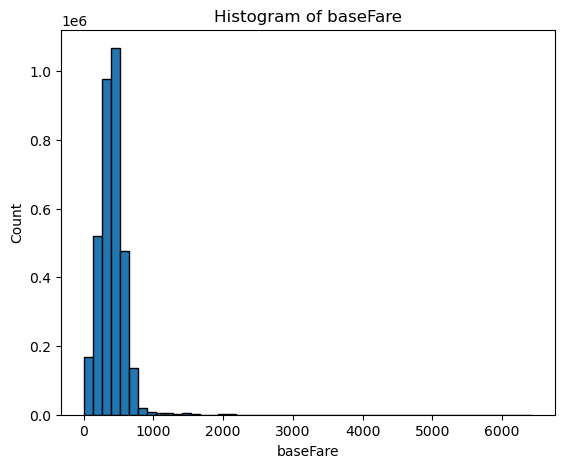

In [18]:
plt.figure(figsize=(14, 5))

# Histogram with matplotlib
plt.subplot(1, 2, 1)
plt.hist(base_fare, bins=50, edgecolor='black')
plt.title("Histogram of baseFare")
plt.xlabel("baseFare")
plt.ylabel("Count")

plt.show()

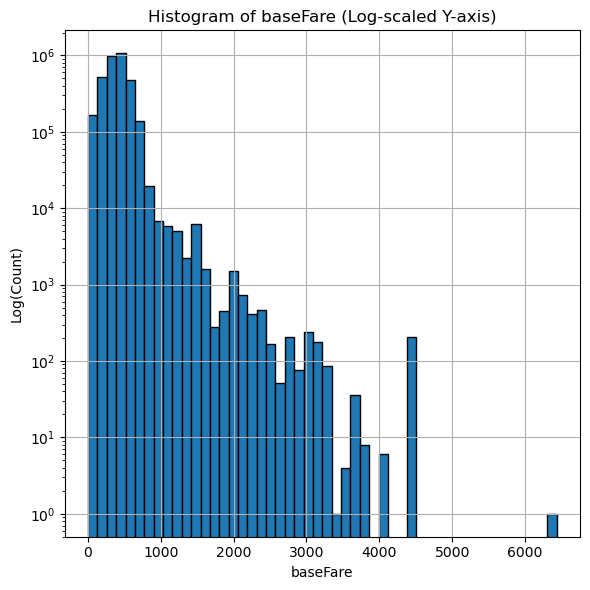

In [30]:
base_fare = df_train_raw1['baseFare']

plt.figure(figsize=(6, 6))

# Histogram with log-scaled y-axis
plt.hist(base_fare, bins=50, edgecolor='black')

# Log-scaled Y-axis
plt.yscale('log')

plt.title("Histogram of baseFare (Log-scaled Y-axis)")
plt.xlabel("baseFare")
plt.ylabel("Log(Count)")
plt.grid(True)

plt.tight_layout()
plt.show()

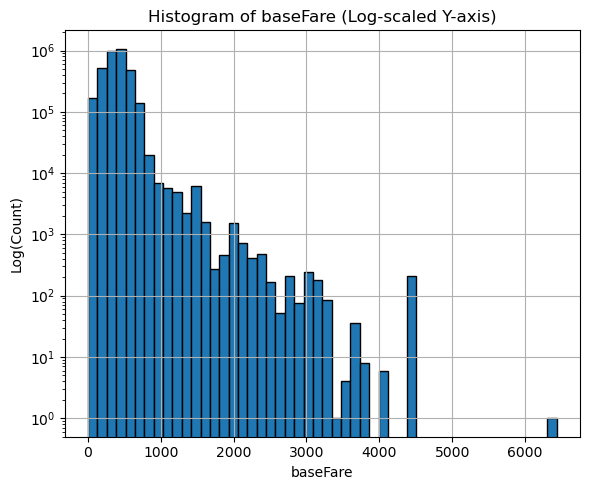

In [35]:
base_fare = df_train_raw1['baseFare']

plt.figure(figsize=(6, 5))

# Histogram with log-scaled y-axis
plt.hist(base_fare, bins=50, edgecolor='black')

# Log-scaled Y-axis
plt.yscale('log')

plt.title("Histogram of baseFare (Log-scaled Y-axis)")
plt.xlabel("baseFare")
plt.ylabel("Log(Count)")
plt.grid(True)

plt.tight_layout()
plt.show()

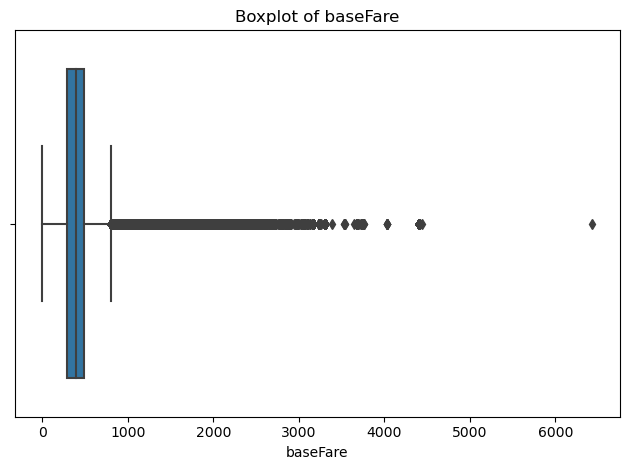

In [21]:
# Boxplot horizontal
sns.boxplot(x=base_fare)
plt.title("Boxplot of baseFare")
plt.xlabel("baseFare")

plt.tight_layout()
plt.show()

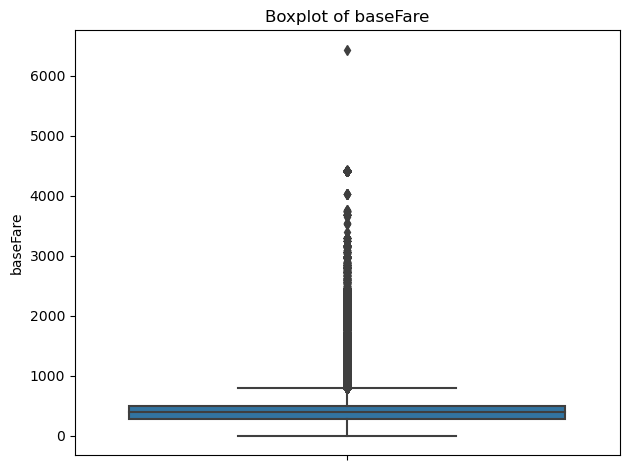

In [23]:
# Boxplot vertical
sns.boxplot(y=base_fare)
plt.title("Boxplot of baseFare")
plt.ylabel("baseFare")
plt.xlabel("")        

plt.tight_layout()
plt.show()

# 2. 2-D Hisgotram Analysis (w/ preprocessed training data)

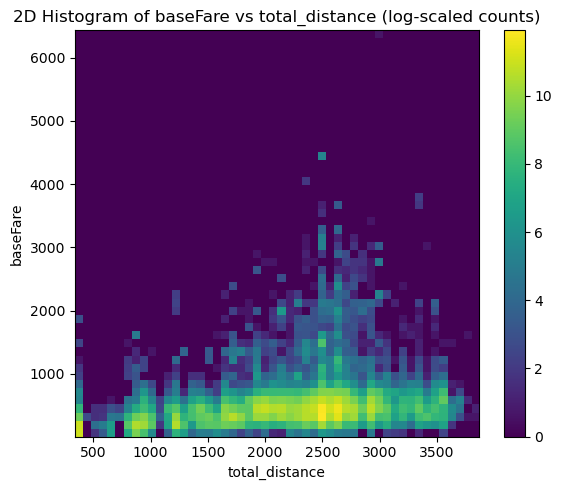

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Plot 1: total_distance vs baseFare
x = df_train_preprocessed_final['total_distance'].values
y = df_train_preprocessed_final['baseFare'].values

# 2D histogram
counts, xedges, yedges = np.histogram2d(x, y, bins=50)
log_counts = np.log1p(counts)  # Log

# Square
fig, ax = plt.subplots(figsize=(6, 5))
pcm = ax.imshow(
    log_counts.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    cmap='viridis'
)
ax.set_title("2D Histogram of baseFare vs total_distance (log-scaled counts)")
ax.set_xlabel('total_distance')
ax.set_ylabel('baseFare')
fig.colorbar(pcm, ax=ax)
plt.tight_layout()
plt.show()

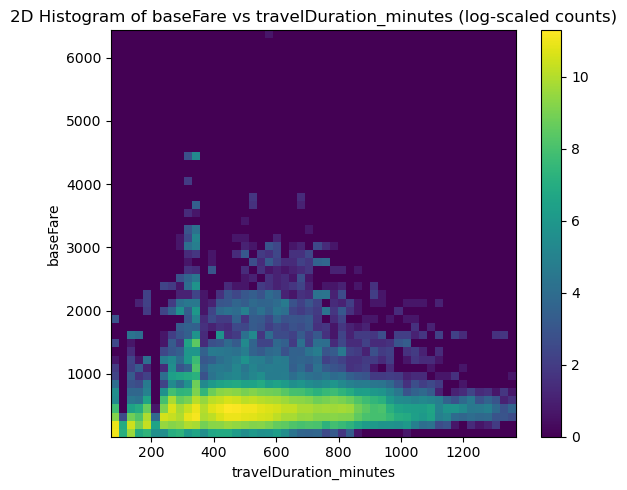

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Plot 2: travelDuration_minutes vs baseFare
x = df_train_preprocessed_final['travelDuration_minutes'].values
y = df_train_preprocessed_final['baseFare'].values

# 2D histogram
counts, xedges, yedges = np.histogram2d(x, y, bins=50)
log_counts = np.log1p(counts)  # Log

# Square
fig, ax = plt.subplots(figsize=(6, 5))
pcm = ax.imshow(
    log_counts.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    cmap='viridis'
)
ax.set_title("2D Histogram of baseFare vs travelDuration_minutes (log-scaled counts)")
ax.set_xlabel('travelDuration_minutes')
ax.set_ylabel('baseFare')
fig.colorbar(pcm, ax=ax)
plt.tight_layout()
plt.show()

# 3. Distributions of flight month and destination before & after the removal

1) Month(flightMonth) Distribution

In [8]:
df_train_raw1['flightMonth'] = pd.to_datetime(df_train_raw1['flightDate']).dt.month
df_train_cleaned1['flightMonth'] = pd.to_datetime(df_train_cleaned1['flightDate']).dt.month

In [9]:
# Month distribution
month_dist_before = df_train_raw1['flightMonth'].value_counts(normalize=True).sort_index()
month_dist_after = df_train_cleaned1['flightMonth'].value_counts(normalize=True).sort_index()

In [10]:
# Count and proportion calculation
month_count_before = df_train_raw1['flightMonth'].value_counts().sort_index()
month_count_after = df_train_cleaned1['flightMonth'].value_counts().sort_index()

month_prop_before = df_train_raw1['flightMonth'].value_counts(normalize=True).sort_index()
month_prop_after = df_train_cleaned1['flightMonth'].value_counts(normalize=True).sort_index()

# DataFrame joint
month_comparison = pd.DataFrame({
    'Count (Before)': month_count_before,
    'Proportion (Before)': month_prop_before,
    'Count (After)': month_count_after,
    'Proportion (After)': month_prop_after
}).fillna(0)

# roundup
month_comparison['Proportion (Before)'] = (month_comparison['Proportion (Before)'] * 100).round(2)
month_comparison['Proportion (After)'] = (month_comparison['Proportion (After)'] * 100).round(2)

print("Flight Month Distribution (Count & Proportion %)")
print(month_comparison)

Flight Month Distribution (Count & Proportion %)
             Count (Before)  Proportion (Before)  Count (After)  \
flightMonth                                                       
4                     84071                 2.47          70502   
5                    729287                21.44         596252   
6                   1209879                35.58         947375   
7                   1377592                40.51        1075760   

             Proportion (After)  
flightMonth                      
4                          2.62  
5                         22.17  
6                         35.22  
7                         39.99  


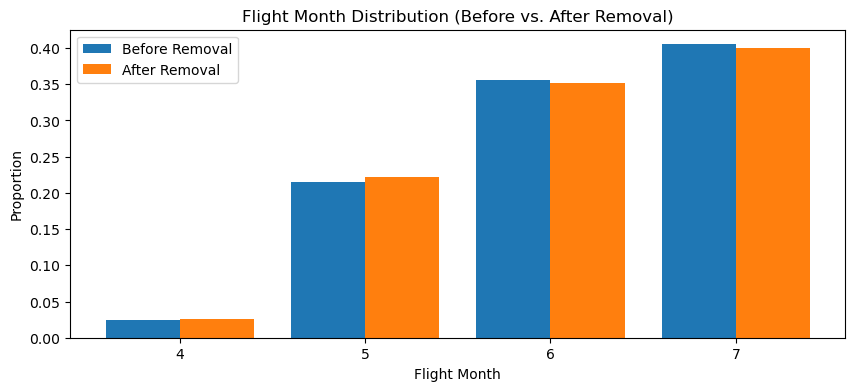

In [11]:
import matplotlib.pyplot as plt

# Flight Month Distribution
plt.figure(figsize=(10, 4))
plt.bar(month_dist_before.index - 0.2, month_dist_before.values, width=0.4, label='Before Removal')
plt.bar(month_dist_after.index + 0.2, month_dist_after.values, width=0.4, label='After Removal')
plt.xlabel("Flight Month")
plt.ylabel("Proportion")
plt.title("Flight Month Distribution (Before vs. After Removal)")
plt.xticks(month_dist_before.index)
plt.legend()
plt.show()

2) Destination(destinationAirport) Distribution

In [12]:
# Destination distribution
dest_dist_before = df_train_raw1['destinationAirport'].value_counts(normalize=True).sort_index()
dest_dist_after = df_train_cleaned1['destinationAirport'].value_counts(normalize=True).sort_index()

In [13]:
# Count and proportion
dest_count_before = df_train_raw1['destinationAirport'].value_counts().sort_index()
dest_count_after = df_train_cleaned1['destinationAirport'].value_counts().sort_index()

dest_prop_before = df_train_raw1['destinationAirport'].value_counts(normalize=True).sort_index()
dest_prop_after = df_train_cleaned1['destinationAirport'].value_counts(normalize=True).sort_index()

# DataFrame joint
dest_comparison = pd.DataFrame({
    'Count (Before)': dest_count_before,
    'Proportion (Before)': dest_prop_before,
    'Count (After)': dest_count_after,
    'Proportion (After)': dest_prop_after
}).fillna(0)

# roundup
dest_comparison['Proportion (Before)'] = (dest_comparison['Proportion (Before)'] * 100).round(2)
dest_comparison['Proportion (After)'] = (dest_comparison['Proportion (After)'] * 100).round(2)

print("\nDestination Airport Distribution (Count & Proportion %)")
print(dest_comparison)


Destination Airport Distribution (Count & Proportion %)
                    Count (Before)  Proportion (Before)  Count (After)  \
destinationAirport                                                       
ATL                         273824                 8.05         209667   
BOS                         300166                 8.83         238707   
CLT                         238367                 7.01         202084   
DEN                         185464                 5.45         155427   
DFW                         242977                 7.14         163517   
DTW                         242376                 7.13         191286   
EWR                         256181                 7.53         207302   
IAD                         176846                 5.20         161174   
JFK                         269257                 7.92         224726   
LGA                         290780                 8.55         241587   
MIA                         220603                 6.49

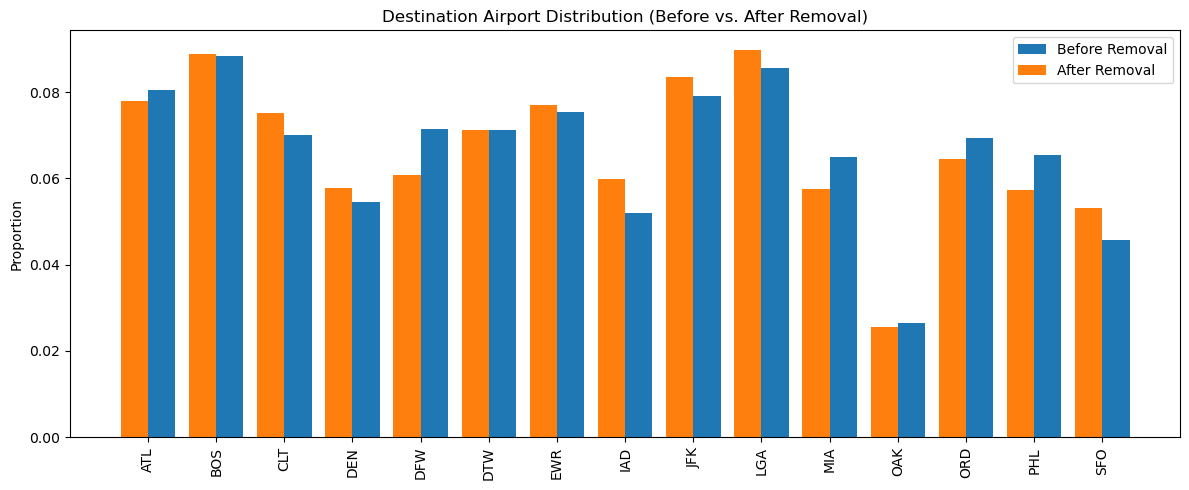

In [14]:
# Destination Airport Distribution
plt.figure(figsize=(12, 5))
common_dest = sorted(set(dest_dist_before.index).intersection(dest_dist_after.index))

plt.bar(range(len(common_dest)), [dest_dist_before[dest] for dest in common_dest], width=0.4, label='Before Removal', align='edge')
plt.bar(range(len(common_dest)), [dest_dist_after[dest] for dest in common_dest], width=-0.4, label='After Removal', align='edge')
plt.xticks(range(len(common_dest)), common_dest, rotation=90)
plt.ylabel("Proportion")
plt.title("Destination Airport Distribution (Before vs. After Removal)")
plt.legend()
plt.tight_layout()
plt.show()